In [57]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim import AdamW
from sentence_transformers import SentenceTransformer, util, losses, InputExample
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.autonotebook import tqdm, trange
from typing import List
import random

# Suppress the specific FutureWarning from huggingface_hub
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")


In [7]:
# Load the probes dataset
probes_df = pd.read_csv("../data/Catalog - Probes.csv")
probes_df = probes_df.drop(['Description'], axis=1)

# Split "Compatible_Systems" column
probes_df['Compatible_Systems'] = probes_df['Compatible_Systems'].str.split(', ')

# Split "Applications" column
probes_df['Applications'] = probes_df['Applications'].str.split(', ')

# Load the systems dataset
systems_df = pd.read_csv("../data/systems.csv")

# Split "compatible_probes" column
systems_df['compatible_probes'] = systems_df['compatible_probes'].str.split(', ')

# Print the head of the dataframes
probes_df.head()

,Manufacturer,Probe_Model,Cartridge_Connection,Compatible_Systems,Array_Type,Applications,Min_Frequency,Max_Frequency,Stock
0,ATL,C3,0,[HDI 5000],convex,"[abdominal, general]",3.0,3.0,0
1,ATL,C4-2,0,[HDI 5000],convex,"[abdominal, obstetric, gynecologic, general]",2.0,4.0,2
2,ATL,C5-2,0,"[HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[abdominal, general]",2.0,5.0,7
3,ATL,C5-IVT,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[intracavitary, endovaginal, gynecological]",4.0,6.0,0
4,ATL,C7-4,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 5000]",convex,"[cardiac, vascular, general]",4.0,7.0,0


In [8]:
systems_df.head()

,ultrasound_system,manufacturer,compatible_probes
0,HDI 5000,ATL,"[C3, C4-2, C5-2, C5-IVT, C7-4, C8-4v, C9-5ICT,..."
1,HDI 1500,ATL,"[C5-2, C5-IVT, C7-4, C9-5ICT, L7-4]"
2,HDI 3000,ATL,"[C5-2, C5-IVT, C7-4, C8-4v, CL 10-5, CT8-4, L7-4]"
3,HDI 3500,ATL,"[C5-2, C5-IVT, C8-4v, CT8-4]"
4,UM9 HDI,ATL,"[C5-IVT, C7-4, L7-4]"


In [9]:
# Function to generate probe descriptions, questions, answers, and relevant documents
def generate_probe_info(row):
    """
    This function takes a row from the probes_df DataFrame and generates lists of probe descriptions, questions, answers, relevant documents, and tags.
    """
    descriptions = []
    questions = []
    answers = []
    relevant_documents = []
    tags = []

    # Manufacturer
    descriptions.append(f"The manufacturer of the {row['Probe_Model']} probe is {row['Manufacturer']}.")
    questions.append(f"Who is the manufacturer of the {row['Probe_Model']} probe?")
    answers.append(row['Manufacturer'])
    relevant_documents.append(f"The manufacturer of the {row['Probe_Model']} probe is {row['Manufacturer']}.")
    tags.append(['probes', 'manufacturer', row['Manufacturer'], row['Probe_Model']])

    # Cartridge Connection
    if row['Cartridge_Connection'] == 1:
        questions.append(f"Does the {row['Manufacturer']} {row['Probe_Model']} have a cartridge connector?")
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe has a variant with a cartridge connection.")
        relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe has a variant with a cartridge connection.")
        answers.append(row['Cartridge_Connection'])
        tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'connection'])

    # Compatible Systems
    compatible_systems = ', '.join(row['Compatible_Systems'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is compatible with the following systems: {compatible_systems}.")
    questions.append(f"Which systems is the {row['Manufacturer']} {row['Probe_Model']} probe compatible with?")
    answers.append(compatible_systems)
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is compatible with the following systems: {compatible_systems}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'compatibility', compatible_systems])

    # Array Type
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} is a {row['Array_Type']} array type probe.")
    questions.append(f"What is the array type of the {row['Manufacturer']} {row['Probe_Model']} probe?")
    answers.append(row['Array_Type'])
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} is a {row['Array_Type']} array type probe.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'array type'])

    # Applications
    applications = ', '.join(row['Applications'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is suitable for the following applications: {applications}.")
    questions.append(f"What applications can the {row['Manufacturer']} {row['Probe_Model']} probe be used for?")  
    answers.append(applications)
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is suitable for the following applications: {applications}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], "applications", applications])

    # Stock
    if row['Stock'] > 0:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently in stock and available for sale.")
    else:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently out of stock or not available for sale.")
    questions.append(f"Do you have any {row['Manufacturer']} {row['Probe_Model']} probes for sale?")
    answers.append(row['Stock'])
    relevant_documents.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently {'in stock and available for sale' if row['Stock'] > 0 else 'out of stock or not available for sale'}.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'stock'])

    # Frequency Range
    descriptions.append(f"The frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe is {row['Min_Frequency']} - {row['Max_Frequency']} MHz.")
    questions.append(f"What is the frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe?")
    answers.append(f"{row['Min_Frequency']} - {row['Max_Frequency']} MHz")
    relevant_documents.append(f"The frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe is {row['Min_Frequency']} - {row['Max_Frequency']} MHz.")
    tags.append(['probes', row['Manufacturer'], row['Probe_Model'], 'frequency'])

    return descriptions, questions, answers, relevant_documents, tags

def generate_system_description(row):
    """
    This function takes a row from the systems_df DataFrame and generates lists of system descriptions, questions, answers, relevant documents, and tags.
    """
    descriptions = []
    questions = []
    answers = []
    relevant_documents = []
    tags = []

    # System manufacturer
    description = f"The {row['ultrasound_system']} ultrasound system is made by {row['manufacturer']}."
    descriptions.append(description)
    questions.append(f"Who is the manufacturer of the {row['ultrasound_system']} ultrasound system?")
    answers.append(row['manufacturer'])
    relevant_documents.append(description)
    tags.append([row['manufacturer'], row['ultrasound_system'], 'manufacturer', 'systems'])

    # System compatible probes
    compatible_probes = ', '.join(row['compatible_probes'])
    description = f"The {row['manufacturer']} {row['ultrasound_system']} ultrasound system is compatible with the following {row['manufacturer']} probes: {compatible_probes}."
    descriptions.append(description)
    questions.append(f"Which probes is the {row['manufacturer']} {row['ultrasound_system']} ultrasound system compatible with?")
    answers.append(compatible_probes)
    relevant_documents.append(description)
    tags.append([row['manufacturer'], row['ultrasound_system'], 'compatibility', 'systems', compatible_probes])

    return descriptions, questions, answers, relevant_documents, tags

# Apply the probe function and directly unpack into separate lists
probe_descriptions, probe_questions, probe_answers, probe_relevant_documents, probe_tags = zip(*probes_df.apply(generate_probe_info, axis=1))

# Apply the system function and directly unpack into separate lists
system_descriptions, system_questions, system_answers, system_relevant_documents, system_tags = zip(*systems_df.apply(generate_system_description, axis=1))

# Flatten the lists since each element is a list of items
all_contents = [item for sublist in (probe_descriptions + system_descriptions) for item in sublist]
all_questions = [item for sublist in (probe_questions + system_questions) for item in sublist]
all_answers = [item for sublist in (probe_answers + system_answers) for item in sublist]
all_relevant_documents = [item for sublist in (probe_relevant_documents + system_relevant_documents) for item in sublist]
all_tags = [item for sublist in (probe_tags + system_tags) for item in sublist]

# Create a DataFrame from these lists
documents_df = pd.DataFrame({
    'content': all_contents,
    'questions': all_questions,
    'relevant_documents': all_relevant_documents,
    'short_answers': all_answers,
    'tags': all_tags
})

documents_df.head()

,content,questions,relevant_documents,short_answers,tags
0,The manufacturer of the C3 probe is ATL.,Who is the manufacturer of the C3 probe?,The manufacturer of the C3 probe is ATL.,ATL,"[probes, manufacturer, ATL, C3]"
1,The ATL C3 probe is compatible with the follow...,Which systems is the ATL C3 probe compatible w...,The ATL C3 probe is compatible with the follow...,HDI 5000,"[probes, ATL, C3, compatibility, HDI 5000]"
2,The ATL C3 is a convex array type probe.,What is the array type of the ATL C3 probe?,The ATL C3 is a convex array type probe.,convex,"[probes, ATL, C3, array type]"
3,The ATL C3 probe is suitable for the following...,What applications can the ATL C3 probe be used...,The ATL C3 probe is suitable for the following...,"abdominal, general","[probes, ATL, C3, applications, abdominal, gen..."
4,The ATL C3 probe is currently out of stock or ...,Do you have any ATL C3 probes for sale?,The ATL C3 probe is currently out of stock or ...,0,"[probes, ATL, C3, stock]"


In [105]:
# Load the models
models = {
    'multi-qa-mpnet-base-dot-v1': SentenceTransformer('multi-qa-mpnet-base-dot-v1'),
    'all-mpnet-base-v2': SentenceTransformer('all-mpnet-base-v2'),
    'multi-qa-distilbert-cos-v1': SentenceTransformer('multi-qa-distilbert-cos-v1')
}

# Generate embeddings for the content and questions
embeddings = {}
for model_name, model in models.items():
    embeddings[model_name] = {
        'content': model.encode(documents_df['content'].tolist(), convert_to_tensor=True, show_progress_bar=True),
        'questions': model.encode(documents_df['questions'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    }

You try to use a model that was created with version 3.0.0.dev0, however, your version is 3.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [106]:
def compute_rr(embeddings, ranking_method):
    results_df = documents_df.copy()
    results_df['absolute_rank'] = 0
    results_df['rr'] = 0.0

    for i, question in enumerate(documents_df['questions']):
        relevant_doc = documents_df['relevant_documents'].iloc[i]
        query_emb = embeddings['questions'][i].unsqueeze(0)  # Add batch dimension

        if ranking_method == 'dot_score':
            scores = util.dot_score(query_emb, embeddings['content'])[0].cpu().tolist()
        elif ranking_method == 'cos_sim':
            scores = util.cos_sim(query_emb, embeddings['content'])[0].cpu().tolist()

        # Combine docs & scores
        doc_score_pairs = list(zip(documents_df['content'], scores))

        # Sort by decreasing score
        doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        # Find the rank of the first relevant document
        matching_indices = [idx for idx, (doc, score) in enumerate(doc_score_pairs) if doc == relevant_doc]
        if len(matching_indices) > 0:
            rank = matching_indices[0] + 1
        else:
            rank = len(doc_score_pairs) + 1  # Relevant document not found

        # Calculate reciprocal rank
        rr = 1 / rank

        # Update the corresponding row in results_df
        results_df.at[i, 'absolute_rank'] = rank
        results_df.at[i, 'rr'] = rr

    return results_df

# Compute RR for each model and ranking method
results = {
    'multi-qa-mpnet-base-dot-v1': compute_rr(embeddings['multi-qa-mpnet-base-dot-v1'], 'dot_score'),
    'all-mpnet-base-v2': compute_rr(embeddings['all-mpnet-base-v2'], 'dot_score'),
    'multi-qa-distilbert-cos-v1': compute_rr(embeddings['multi-qa-distilbert-cos-v1'], 'cos_sim')
}

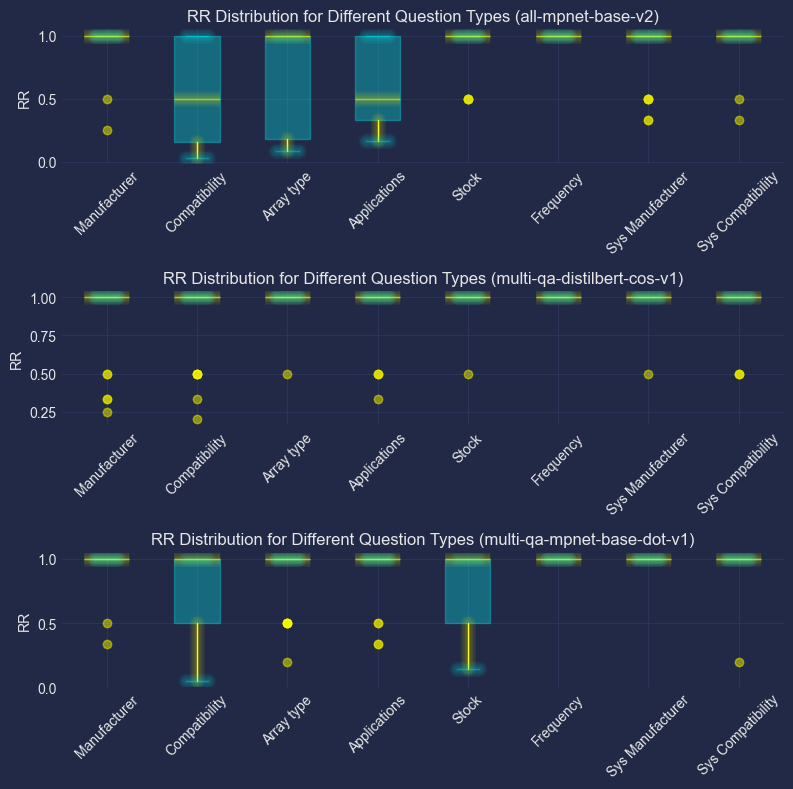

In [113]:
import mplcyberpunk

# Set the style to cyberpunk
plt.style.use("cyberpunk")

# Define the order of models
model_order = ['all-mpnet-base-v2', 'multi-qa-distilbert-cos-v1', 'multi-qa-mpnet-base-dot-v1']

# Filter RR values for different 'probes' and 'systems' question types
probe_types = ['manufacturer', 'compatibility', 'array type', 'applications', 'stock', 'frequency']
system_types = ['manufacturer', 'compatibility']

results_rr_by_type = {key: {ptype: df[df['tags'].apply(lambda x: 'probes' in x and ptype in x)]['rr'].dropna() for ptype in probe_types} for key, df in results.items()}

# Add 'systems' question types to the results
for key, df in results.items():
    results_rr_by_type[key].update({f'systems_{stype}': df[df['tags'].apply(lambda x: 'systems' in x and stype in x)]['rr'].dropna() for stype in system_types})

# Define the complete list of question types
all_types = probe_types + [f'systems_{stype}' for stype in system_types]
labels = [ptype.capitalize() for ptype in probe_types] + [f'Sys {stype.capitalize()}' for stype in system_types]

# Create the boxplot
fig, ax = plt.subplots(len(model_order), 1, figsize=(8, 8))  # Adjust the figure size

for i, model_key in enumerate(model_order):
    rr_by_type = results_rr_by_type[model_key]
    data = [rr_by_type[ptype] for ptype in all_types if ptype in rr_by_type]
    box = ax[i].boxplot(data, vert=True, patch_artist=True, medianprops=dict(color='yellow', alpha=0.5), boxprops=dict(facecolor='cyan', alpha=0.3, edgecolor='cyan'), capprops=dict(color='cyan', alpha=0.3), whiskerprops=dict(color='yellow'), flierprops=dict(markeredgecolor='yellow', markerfacecolor='yellow', alpha=0.3))
    ax[i].set_xticklabels(labels, rotation=45)
    ax[i].set_ylabel('RR')
    ax[i].set_title(f'RR Distribution for Different Question Types ({model_key})')

    mplcyberpunk.make_lines_glow(ax[i])

plt.tight_layout()
plt.savefig('../images/boxplot.png', dpi=96, bbox_inches='tight')
plt.show()

c:\Users\denni\anaconda3\envs\chatbot\Lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


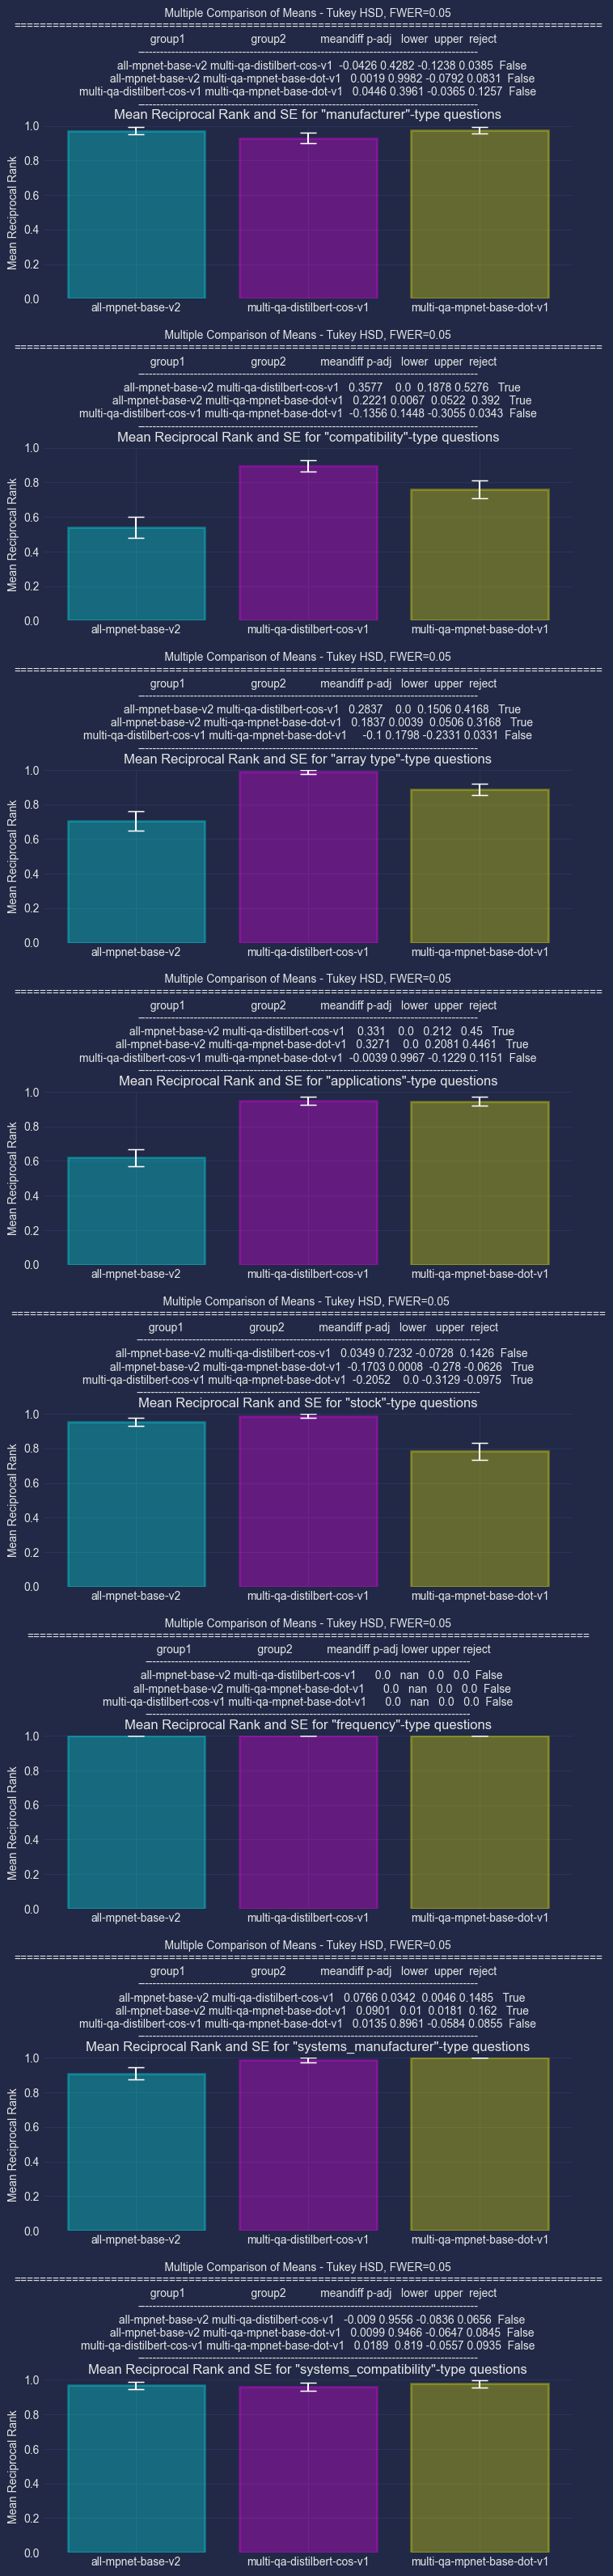

In [114]:
# Calculate means and standard errors
mean_rr_by_type = {}
se_rr_by_type = {}
tukey_results = {}

for ptype in all_types:
    mean_rr_by_type[ptype] = []
    se_rr_by_type[ptype] = []
    tukey_data = []
    for model_name in model_order:  # Use the defined model order
        rr_by_type = results_rr_by_type[model_name][ptype]
        mean_rr = np.mean(rr_by_type)
        se_rr = np.std(rr_by_type) / np.sqrt(len(rr_by_type))  # Standard Error of the mean
        mean_rr_by_type[ptype].append(mean_rr)
        se_rr_by_type[ptype].append(se_rr)
        tukey_data.extend([(ptype, model_name, rr) for rr in rr_by_type])

    # Prepare data for Tukey's HSD test
    tukey_df = pd.DataFrame(tukey_data, columns=['QuestionType', 'Model', 'RR'])
    tukey_result = pairwise_tukeyhsd(endog=tukey_df['RR'],
                                     groups=tukey_df['Model'],
                                     alpha=0.05)
    tukey_results[ptype] = tukey_result

# Colors for different models
colors = ['cyan', 'magenta', 'yellow']

fig, axes = plt.subplots(nrows=len(all_types), figsize=(8, 4 * len(all_types)))

if len(all_types) == 1:
    axes = [axes]

for ax, ptype in zip(axes, all_types):
    # Data for plotting
    means = mean_rr_by_type[ptype]
    errors = se_rr_by_type[ptype]
    x = np.arange(len(means))

    # Creating bar chart
    bars = ax.bar(x, means, yerr=errors, color=colors, capsize=7, alpha=0.3, linewidth=2, ecolor='white')
    for bar, color in zip(bars, colors):
        bar.set_edgecolor(color)
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_title(f'Mean Reciprocal Rank and SE for "{ptype}"-type questions')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Mean Reciprocal Rank')
    ax.set_yticks(np.linspace(0, 1, 6))

    # Add cyberpunk-style effects
    mplcyberpunk.make_lines_glow(ax, alpha_line=0.6)

    # Print Tukey's HSD results above the bar chart
    ax.text(0.5, 1.1, str(tukey_results[ptype]), transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.savefig('../images/bar_chart.png', dpi=96, bbox_inches='tight')
plt.show()

In [58]:
# Define the custom loss function
class CosineSimilarityLoss(nn.Module):
    def __init__(self, cos_score_transformation=None):
        super(CosineSimilarityLoss, self).__init__()
        self.cos_score_transformation = cos_score_transformation
        self.loss_fct = nn.CosineEmbeddingLoss(reduction='mean')

    def forward(self, embeddings, labels):
        return self.loss_fct(embeddings[0], embeddings[1], labels)
    
def collate_batch(batch):
    questions = [example.texts[0] for example in batch]
    contents = [example.texts[1] for example in batch]
    labels = [example.label for example in batch]
    return questions, contents, torch.tensor(labels)



In [65]:
# Get unique questions
unique_questions = documents_df['questions'].unique()

# Split unique questions into train, val, and test
train_questions, temp_questions = train_test_split(unique_questions, test_size=0.3, random_state=42)
val_questions, test_questions = train_test_split(temp_questions, test_size=0.5, random_state=42)

# Create examples based on the split
train_examples = []
val_examples = []
test_examples = []

for question in train_questions:
    content = documents_df[documents_df['questions'] == question]['content'].values[0]
    tags = set(documents_df[documents_df['questions'] == question]['tags'].values[0])  # Convert list to set
    positive_tags = tags - {'probes', 'systems'}
    train_examples.append(InputExample(texts=[question, content], label=1))
    for tag in positive_tags:
        train_examples.append(InputExample(texts=[question, tag], label=-1))

for question in val_questions:
    content = documents_df[documents_df['questions'] == question]['content'].values[0]
    tags = set(documents_df[documents_df['questions'] == question]['tags'].values[0])  # Convert list to set
    positive_tags = tags - {'probes', 'systems'}
    val_examples.append(InputExample(texts=[question, content], label=1))
    for tag in positive_tags:
        val_examples.append(InputExample(texts=[question, tag], label=-1))

for question in test_questions:
    content = documents_df[documents_df['questions'] == question]['content'].values[0]
    tags = set(documents_df[documents_df['questions'] == question]['tags'].values[0])  # Convert list to set
    positive_tags = tags - {'probes', 'systems'}
    test_examples.append(InputExample(texts=[question, content], label=1))
    for tag in positive_tags:
        test_examples.append(InputExample(texts=[question, tag], label=-1))

# Create data loaders
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32, collate_fn=collate_batch)
val_dataloader = DataLoader(val_examples, batch_size=32, collate_fn=collate_batch)
test_dataloader = DataLoader(test_examples, batch_size=32, collate_fn=collate_batch)



Epoch 1, Training Loss: 0.2956324758068208, Validation Loss: 0.30619771565709797
Epoch 2, Training Loss: 0.29910587303100095, Validation Loss: 0.30619771565709797
Epoch 3, Training Loss: 0.29575165481336657, Validation Loss: 0.30619771565709797
Epoch 4, Training Loss: 0.29796888126480964, Validation Loss: 0.30619771565709797
Epoch 5, Training Loss: 0.2984514548893898, Validation Loss: 0.30619771565709797
Epoch 6, Training Loss: 0.29853826424767893, Validation Loss: 0.30619771565709797
Epoch 7, Training Loss: 0.2983440497229176, Validation Loss: 0.30619771565709797
Epoch 8, Training Loss: 0.29905754712320143, Validation Loss: 0.30619771565709797
Epoch 9, Training Loss: 0.29633338364862627, Validation Loss: 0.30619771565709797
Epoch 10, Training Loss: 0.2981061190366745, Validation Loss: 0.30619771565709797


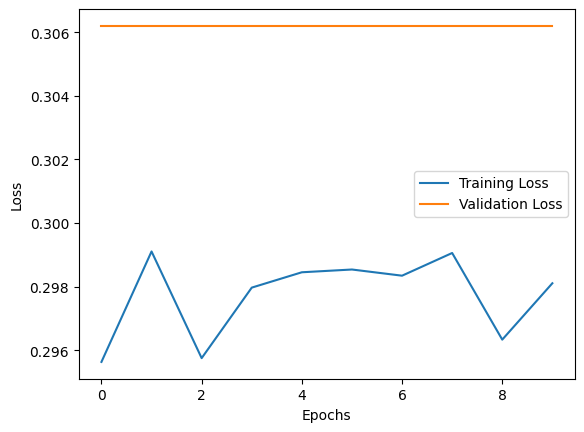

In [66]:
# Load the pre-trained model
model = SentenceTransformer('multi-qa-distilbert-cos-v1')

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

loss_fn = CosineSimilarityLoss(cos_score_transformation=lambda x: x)

# Lists to store loss values
train_losses = []
val_losses = []

def validate_model(model, val_dataloader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_questions, batch_contents, batch_labels in val_dataloader:
            question_emb = model.encode(batch_questions, convert_to_tensor=True)
            content_emb = model.encode(batch_contents, convert_to_tensor=True)
            loss = loss_fn([question_emb, content_emb], batch_labels)
            val_loss += loss.item()
    return val_loss / len(val_dataloader)

# Fine-tune the model
for epoch in range(10):
    model.train()
    train_loss = 0
    for batch_questions, batch_contents, batch_labels in train_dataloader:
        question_emb = model.encode(batch_questions, convert_to_tensor=True)
        content_emb = model.encode(batch_contents, convert_to_tensor=True)
        
        # Ensure gradients are enabled
        question_emb.requires_grad_(True)
        content_emb.requires_grad_(True)
        
        loss = loss_fn([question_emb, content_emb], batch_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    avg_val_loss = validate_model(model, val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [61]:
# Ensure no overlap between training and validation sets
train_questions = set([example.texts[0] for example in train_examples])
val_questions = set([example.texts[0] for example in val_examples])
overlap = train_questions.intersection(val_questions)
print(f"Overlap between training and validation sets: {len(overlap)}")

Overlap between training and validation sets: 115
